# Vehicle Detection

# Stage 0: Preperation

In [1]:
'''# imports'''
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

# set random seed
np.random.seed = 2

# Stage 1: Feature Extraction and Classifier Training

In [2]:
'''some useful functions for feature extraction'''

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,scg=[True,True,True],print_len=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        if isinstance(file,str):
        # If the file is a filename in string, Read in each one by one
            image = mpimg.imread(file)
        else:
            image = file
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 
        
        
        spatial_features=np.array([])
        hist_features=np.array([])
        hog_features=np.array([])
        
        # Apply bin_spatial() to get spatial color features
        if scg[0]:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        if scg[1]:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if scg[2]:
            if hog_channel == "all":
                hog_features = np.concatenate(
                        [get_hog_features(image[:,:,i]) for i in range(3)])
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

                
        if print_len:
            print(len(spatial_features), len(hist_features), len(hog_features))
                
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        #features.append(np.concatenate(( hist_features, hog_features)))
        #features.append(hog_features)
    # Return list of feature vectors
    return features



In [3]:
'''better evaluation metric: AUC'''
from sklearn.metrics import roc_auc_score

In [4]:
#'''read the cars'''
cars=glob.glob("vehicles/*/*.png")
notcars=glob.glob("non-vehicles/GTI/*.png")

## Feature Extraction&Bottleneck Data Generation

In [5]:
'''the detector model's class '''

class Model(object):
    def __init__(self,feature_extractor):
        self.svc = None
        self.X_scaler = None
        self.extract = feature_extractor
        
    def getModel(self,X,y):
        '''return the X_scaler and the Model'''
                                
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Split up data into randomized training and test sets
        rand_state = 2017
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # train classifier
        # Use a linear SVC 
        svc = LinearSVC(random_state=rand_state)
        # Check the training time for the SVC
        %time svc.fit(X_train, y_train)
        # Check the score of the SVC
        print('Test AUC of SVC = ', roc_auc_score(y_test,svc.predict(X_test)))
        
        self.X_scaler = X_scaler
        self.svc = svc
        
    def pred(self,img):
        '''pipeline for image predicting'''
        img_features = self.extract([img])
        x = self.X_scaler.transform(img_features)
        return self.svc.predict(x)[0]
        

In [6]:
'''get the functool'''
from functools import partial

In [7]:
# '''get the features out as X and y'''
def training_data_generation(extract):
    global cars,notcars

    # read them as images
    car_imgs = list(map(plt.imread, cars))
    notcar_imgs = list(map(plt.imread, notcars))

    # TODO: get the flipped images
    flip = partial(cv2.flip,flipCode=1)
    car_flipped = list(map(flip,car_imgs))
    notcar_flipped = list(map(flip,notcar_imgs))

    # TODO: get the flipped notcar images
    vflip = partial(cv2.flip,flipCode=0)
    notcar_flipped += list(map(vflip,notcar_imgs))
    vhflip = partial(cv2.flip,flipCode=-1)
    notcar_flipped += list(map(vhflip,notcar_imgs))

    car_features = extract(car_imgs+car_flipped)
    notcar_features = extract(notcar_imgs+notcar_flipped)
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)  
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return X,y

In [8]:
#'''generate them'''
extract = partial(extract_features,cspace="YCrCb",spatial_size=(16,16),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="all",scg=[True,True,True],print_len=False)
X,y = %time training_data_generation(extract)

CPU times: user 1min 59s, sys: 4.73 s, total: 2min 4s
Wall time: 2min 5s


In [9]:
# use decision tree to get the feature importance
from sklearn.tree import DecisionTreeClassifier
print("start training")

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = 2017
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# train classifier
# Use a decision tree
dt = DecisionTreeClassifier(random_state = 2017)
# Check the training time for the SVC
%time dt.fit(X_train, y_train)
# Check the score of the SVC
print('Test AUC of SVC = ', roc_auc_score(y_test,dt.predict(X_test)))


start training
CPU times: user 11min 58s, sys: 4.24 s, total: 12min 2s
Wall time: 12min 6s
Test AUC of SVC =  0.946513723571


In [10]:
# TODO: get the feature importance
fi = dt.feature_importances_
# this step tells that which feature, spatial ch or hog, gives the most role
# 864, [2628.0, 4392.0, 6156.0
list(map(sum,[fi[0:768],fi[768:864],fi[864:2628],fi[2628:4392],fi[4392:6156]]))

[0.65615026571052404,
 0.0,
 0.040474370515137449,
 0.23248281952197178,
 0.070892544252366685]

In [ ]:
# Generate new function 
# and new set of data 
# according to the feature importance
# HINT: use func tools

extract = partial(extract_features,cspace="YCrCb",spatial_size=(16,16),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,scg=[True,True,True],print_len=False)

X,y = training_data_generation(extract)

In [ ]:
X.shape,y.mean()

In [12]:
# TODO: train the svc model according to new features
# which is fast and good
svc_model = Model(extract)
svc_model.getModel(X,y)

CPU times: user 8.91 s, sys: 3.2 s, total: 12.1 s
Wall time: 14.4 s
Test AUC of SVC =  0.990338918411


In [13]:
# TODO: store the model
with open("SVC_s16_ch_g012_newdata_2.pkl","wb") as f:
    pickle.dump(svc_model,f)

In [ ]:
# TODO: test the performance in images in cell below

In [14]:
'''read the test images'''
test_images=[plt.imread(img) for img in glob.glob("test_images/*.jpg")]

In [15]:
'''rectangle drawing'''
def rect(img,predictions,color=(0,0,255),thick=3):
    '''draw rects in a copy of an img and return it'''
    drawon = np.copy(img)
    for start,end in predictions:
        cv2.rectangle(drawon,start,end,color,thick)
    return drawon

In [16]:
'''define the parameter dict'''
params={}

# Stage 2: Sliding Windows and Detecting
Awesome performance for the model trained!

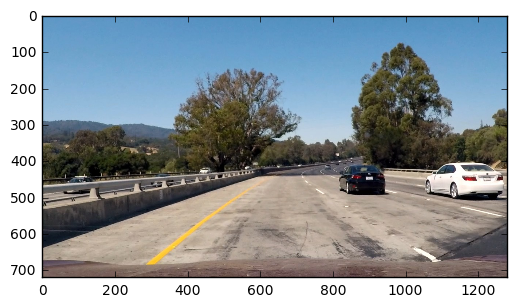

In [17]:
'''read the road img'''
roadimg=plt.imread("test_images/test1.jpg")
plt.imshow(roadimg)

In [18]:
'''define the sliding windows function'''
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img,avg=False,basic_size=0):
    global params
    
    '''
    This function is forked from the course and I made some change on it.
    The changes I made are:
    1. The span of image is the bottom half in default
    2. The size of windows grow larger and larger when sliding further 
       from the center of the image
    3. Work as a generator
    
    The parameter "avg" is for average sliding(basic) or changed sliding
    
    ''' 
    if basic_size==0: # if basic_size is not defined
        basic_size=params["basic"]
    x_overlap=0.5
    num_ver_slides=params["slides"]
    width_basic=params["width"]
    # if not avg, the basic got a init value
    if avg:
        basic = basic_size
    else:
        basic = int(basic_size*(img.shape[0]/2)/(num_ver_slides))
    for i in range(1,num_ver_slides):
        # start and end position for this verticle slide
        # update: from 1 because 0 would cause plenty of false positives
        dist_from_centr = ((img.shape[0]/2)/num_ver_slides) * (i+1)
        ey = int((img.shape[0]/2) + dist_from_centr)
        # if avg, the win size is avg
        if avg:
            win_size = basic
        else:
            win_size = basic*(i+1) # the windows size grows linearly when sliding out
        sy = int(ey-win_size)
        
        # get the start and width of x
        mid = img.shape[1]//2
        width=width_basic*basic*(i+1)
        
        if width>mid:
            width=mid
        
        x_start=mid-width
        
        
        # slide across x
        nx_pix_per_step = int(win_size*(1-x_overlap)) 
        # OK, is that cool to use python.int, not np.int?
        num_hori_slides = int(2*width/nx_pix_per_step) - 1
        
        for j in range(num_hori_slides):
            sx = x_start+nx_pix_per_step * j
            ex = sx + win_size
            yield (sx,sy),(ex,ey)

In [19]:
'''params of sliding windows'''
params["basic"]=1
params["slides"]=16
params["width"]=4

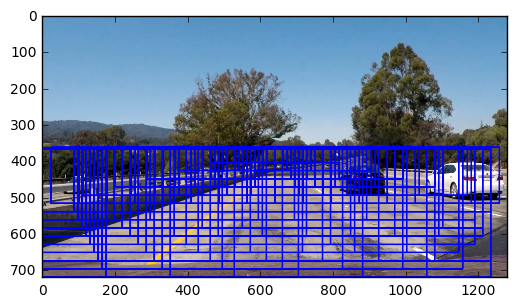

In [20]:
# test the sliding
plt.imshow(rect(roadimg,slide_window(roadimg)))

In [21]:
'''define the normalization function'''
def normalize(x):
    return np.float32((x - x.min())/(x.max() - x.min()))
    

# Stage 3: Improve the Performance of the Model

In [22]:
'''performance evaluation'''
def modelEval():
    global params
    for roadimg in test_images:
        detector = vehicle_detect(roadimg,params["clf"])
        img = rect(roadimg,detector)
        plt.imshow(img)
        plt.show()
    print("-"*10)

In [ ]:
# train it using data
params["clf"] = Model()
params["clf"].getModel(X,y)

In [ ]:
# use model
params["clf"] = svc_model

# Note: becareful when use params again, params are okay, thanks, maybe *args and **kwargs is cool

In [ ]:
# use load
with open("SVC_s16_ch_g0.pkl","rb") as f:
    svc_load_model = pickle.load(f)
params["clf"] = svc_load_model

In [23]:
'''vehicle detection function'''
def vehicle_detect(roadimg,model,plot=False):
    slider = slide_window(roadimg)
    pos_preds = []
    for start,end in slider:
        part = roadimg[start[1]:end[1],start[0]:end[0],:]
        part_resized = cv2.resize(part,(64,64))
        part_norm = normalize(part_resized)
        if model.pred(part_norm)==1.0:
            if plot==2:
                plt.imshow(part_norm)
                plt.show()
                print("---")
            pos_preds.append((start,end))
            
    # if plot, give a show
    if plot==1:
        plt.imshow(rect(roadimg,pos_preds))
        plt.show()
        
    return pos_preds

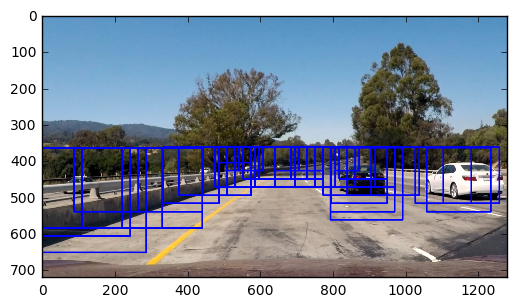

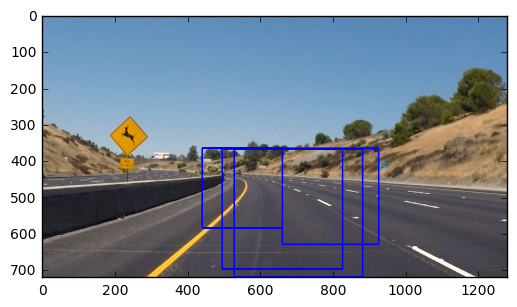

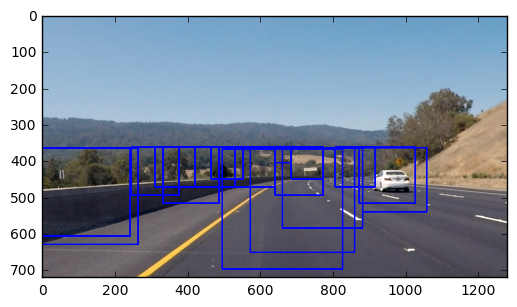

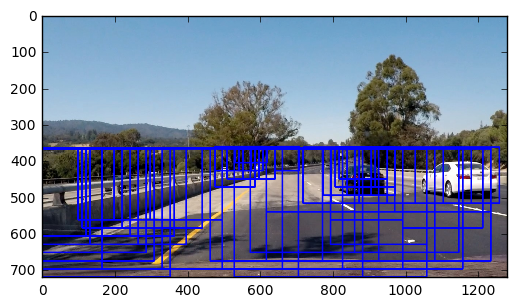

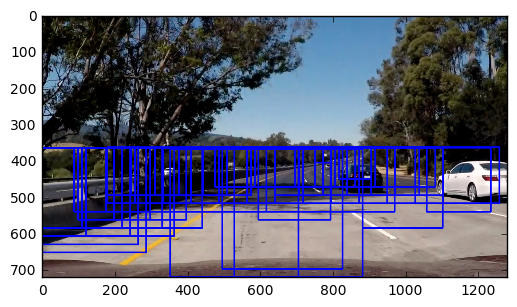

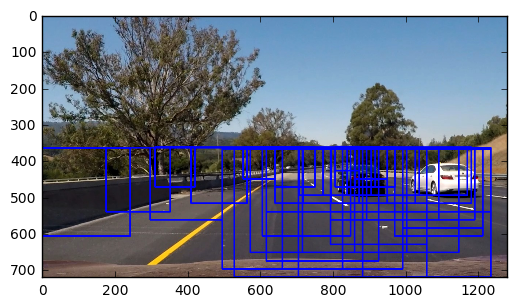

In [24]:
for img in test_images:
    vehicle_detect(img,svc_model,1)

In [ ]:
for img in test_images:
    vehicle_detect(img,svc_load_model,True)

In [ ]:
#'''params check'''
params

In [25]:
'''get the heatmap according to the prediction'''
def heatmap(img,preds):
    hm = np.zeros(img.shape[:2])
    for start,end in preds:
        hm[start[1]:end[1],start[0]:end[0]]+=1
    return hm

In [26]:
'''get the heatmap according to the prediction'''
def pred_and_heatmap(img,model,plot=False):
    global params
    detector = vehicle_detect(img,model)
    hm = heatmap(img,detector)
    hm = (hm - hm.min()) / (hm.max() - hm.min()) #normalize
    if plot:
        plt.imshow(hm,cmap="gray")
        plt.show()
    return hm

# Stage 4: Eliminating False Positives and Duplications

In [27]:
'''# heatmap for duplication reduction'''
class LastNFrames(object):
    def __init__(self,n):
        self.queue=[]
        self.n=n
    def join(self,item):
        '''join the queue, and pop the first item if the queue is full'''
        self.queue.append(item)
        if len(self.queue)>self.n:
            self.queue.pop(0)
    def init_with_default(self,default):
        '''init the queue which fulfilled with default term'''
        self.queue=[default for i in range(self.n)]

def heatmap_generate(hm,lnf):
    '''valid the prediction in heatmap, to eliminate the false positives'''
    
    # join the pred
    lnf.join(hm)
    
    # get the result
    hm_total = np.zeros_like(hm)
    
    for hm_sub in lnf.queue:
        hm_total += hm_sub
        
    
    # normalize
    hm_total = (hm_total - hm_total.min()) / (hm_total.max() - hm_total.min())
    
    
    return hm_total
    
        

# Stage 5: Test On Videos

In [34]:
'''pipeline'''
def process_image(img):
    global LNF,svc_model
    
    output=np.copy(img)
    
    hm = pred_and_heatmap(img,svc_model)
    
    hm_total = heatmap_generate(hm,LNF)
    
    output[0:360,640:1280,:] = cv2.resize((np.dstack((hm,hm,hm))*255),(640,360))
    
    output[0:360,0:640,:] = cv2.resize((np.dstack((hm_total,hm_total,hm_total))*255),(640,360))
    
    return output

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
from datetime import datetime
# trial init
trial_i=600

In [31]:
dtn=datetime.now()

In [32]:
# video generation
def video_generation(output_filename,sub1,sub2):
    global trial_i
    video_output = output_filename
    clip1 = VideoFileClip("project_video.mp4").subclip(sub1,sub2)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(video_output, audio=False)
    trial_i+=1
    return video_output

In [36]:
# params["n_lnf"]=50
# params["hm_thre"]=0.7
LNF=LastNFrames(10)
output_filename='trial %d %s.mp4'%(trial_i,datetime.now().strftime("%Y-%m-%d %H"))
video_generation(output_filename,0,40)

[MoviePy] >>>> Building video trial 601 2017-03-05 21.mp4
[MoviePy] Writing video trial 601 2017-03-05 21.mp4


100%|█████████▉| 1000/1001 [12:21<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: trial 601 2017-03-05 21.mp4 

CPU times: user 11min 53s, sys: 33.1 s, total: 12min 26s
Wall time: 12min 21s


'trial 601 2017-03-05 21.mp4'

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))